In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.linear_model import RidgeClassifier

from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import RobustScaler, label_binarize
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.neighbors import NearestNeighbors

from smote_variants import SMOTE

import optuna
from optuna.pruners import HyperbandPruner, MedianPruner, PatientPruner
from optuna.samplers import TPESampler

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('../data/scaled_features_anomalies_data.csv').set_index('Date')
data.index = pd.to_datetime(data.index)

In [3]:
logs = pd.read_csv('../data/regime_features.csv')['^GSPC']

# 📊 1. Data Preproccessing

In [4]:
features = data.drop(columns='cluster')
target = data['cluster']

## 📅 1.1. Constructing Time Windows for Input Data

In the first stage of data preparation, we construct rolling time windows of fixed length.  
Each window spans the past **7 days** and serves as a single input sample.

For every window, we include:
- All relevant **features** available during that period
- The **target values** (i.e., market regimes) that actually occurred during the same week

This means that the model receives both the explanatory variables and the actual market regime for that time window — with the benefit of hindsight.  
In other words, we are explicitly providing the true regime labels alongside the features, as part of the input, to guide model learning.


In [5]:
def make_windows(x_df, y_series, window_size):
    x_values = x_df.values
    y_values = y_series.values.reshape(-1, 1)

    combined = np.concatenate([x_values, y_values], axis=1)

    x_windows, y_labels = [], []
    for i in range(len(combined) - window_size):
        x_windows.append(combined[i : i + window_size])
        y_labels.append(y_values[i + window_size][0])

    return np.array(x_windows), np.array(y_labels)

In [6]:
x, y = make_windows(features, target, 7)
print(x.shape, y.shape)

(2411, 7, 56) (2411,)


## 🧪 1.2. Hierarchical Time Series Train-Test Split

In this step, we split the dataset in a **hierarchical and temporally consistent** manner.

#### ⬇️ Why this matters:

When working with time series data, it is essential to avoid data leakage across time.  
Random shuffling is **not allowed**, because future data must never influence past predictions.

Instead, we use a two-level split:

1. **First split** — separates the data into training and testing sets, preserving chronological order.
2. **Second split** — further divides the test set into validation and holdout test sets (also in order).

This results in:
- Training set: early data the model is trained on
- Validation set: used during hyperparameter tuning
- Test set: held out entirely to evaluate generalization on unseen data

Each window retains its full structure:
- Shape `(samples, window_length, features)`
- Then reshaped into flat form `(samples, window_length × features)` for model input

This hierarchical split ensures robust, leakage-free training and evaluation — crucial in financial and temporal prediction tasks.

In [7]:
def train_test_teimeseries (features, target, test_size=0.25):
    length = len(features)
    train_size = int(length*(1-test_size))

    x_train, x_test = features[:train_size], features[train_size:]
    y_train, y_test = target[:train_size], target[train_size:]
    
    return x_train, x_test, y_train, y_test

In [8]:
x_train, x_test, y_train, y_test = train_test_teimeseries(x, y)
x_test, x_val, y_test, y_val = train_test_teimeseries(x_test, y_test, 0.5)

In [9]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_val.shape, y_val.shape)

(1808, 7, 56) (1808,)
(301, 7, 56) (301,)
(302, 7, 56) (302,)


In [10]:
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)
x_val_flat = x_val.reshape(x_val.shape[0], -1)

In [11]:
print(x_train_flat.shape, y_train.shape)
print(x_test_flat.shape, y_test.shape)
print(x_val_flat.shape, y_val.shape)

(1808, 392) (1808,)
(301, 392) (301,)
(302, 392) (302,)


## ⚖️ 1.3. Class Rebalance

As we can see, there is a noticeable **class imbalance** in the target distribution.  
Imbalanced datasets can negatively impact the performance of classification algorithms,  
as the model tends to favor the majority class and underperform on the minority classes.

To address this issue, we apply **SMOTE** *(Synthetic Minority Oversampling Technique)*,  
which generates synthetic samples for underrepresented classes by interpolating between existing examples.  
This helps balance the dataset and allows the model to better learn the decision boundaries for all classes.

In [12]:
target.value_counts()

cluster
2    1758
1     352
0     308
Name: count, dtype: int64

In [13]:
class SimpleSMOTE:
    """
    A minimal implementation of the SMOTE (Synthetic Minority Over-sampling Technique) algorithm.
    
    smote addresses class imbalance by generating synthetic samples for minority classes.
    synthetic examples are created by interpolating between existing samples and their nearest neighbors.

    parameters:
        k_neighbors (int): number of nearest neighbors to use for generating synthetic samples (default: 5)
    """

    def __init__(self, k_neighbors=5):
        self.k = k_neighbors

    def fit_resample(self, x, y):
        """
        resample the dataset by oversampling the minority classes using synthetic samples.

        parameters:
            x (np.ndarray): feature matrix of shape (n_samples, n_features)
            y (np.ndarray): target vector of shape (n_samples,)

        returns:
            x_res (np.ndarray): resampled feature matrix including synthetic samples
            y_res (np.ndarray): resampled target vector
        """
        x_res = x.copy()
        y_res = y.copy()

        classes, counts = np.unique(y, return_counts=True)
        majority_class = classes[np.argmax(counts)]
        max_count = np.max(counts)

        for cls in classes:
            if cls == majority_class:
                continue  # skip majority class

            x_minority = x[y == cls]
            n_samples = max_count - x_minority.shape[0]

            if x_minority.shape[0] < self.k:
                continue  # not enough samples to apply smote

            nn = NearestNeighbors(n_neighbors=self.k + 1).fit(x_minority)
            neighbors = nn.kneighbors(x_minority, return_distance=False)[:, 1:]

            synthetic_samples = []
            for _ in range(n_samples):
                i = np.random.randint(0, x_minority.shape[0])
                nn_idx = np.random.choice(neighbors[i])
                diff = x_minority[nn_idx] - x_minority[i]
                gap = np.random.rand()
                synthetic = x_minority[i] + gap * diff
                synthetic_samples.append(synthetic)

            x_res = np.vstack([x_res, synthetic_samples])
            y_res = np.hstack([y_res, [cls] * n_samples])

        return x_res, y_res

In [14]:
smote = SimpleSMOTE()
x_train_balanced, y_train_balanced = smote.fit_resample(x_train_flat, y_train)

In [15]:
pd.Series(y_train_balanced).value_counts()

0    1276
2    1276
1    1276
Name: count, dtype: int64

## 💡 1.4. Create a Function to Evaluate the Model

We will evaluate model performance using four standard classification metrics:

1. **`accuracy_score`** – Overall correctness:  
   Ratio of correct predictions to total samples. Can be misleading with imbalanced classes.

2. **`precision`** – Correctness among predicted positives:  
   Useful when false positives are costly.

3. **`recall`** – Coverage of actual positives:  
   Important when missing true cases is critical.

4. **`f1_score`** – Harmonic mean of precision and recall:  
   Balances both types of error; suitable for imbalanced data.  
   We will use `f1_score` as the main scorer for model tuning.

In [16]:
def evaluate_model(y_true, y_pred):
    results = {}
    results['f1_score'] = f1_score(y_true, y_pred, average='macro')
    results['accuracy'] = accuracy_score(y_true, y_pred)
    results['precision'] = precision_score(y_true, y_pred, average='macro')
    results['recall'] = recall_score(y_true, y_pred, average='macro')
    return results

# 🏞 2. RidgeClassifier: Baseline Model with Grid Search

As a baseline, we train a **Ridge Classifier** - a linear classification model with L2 regularization.

Since Ridge has only one key hyperparameter, `alpha`, we apply a **Grid Search** to find its optimal value.

We use this model as a reference point to evaluate improvements in a more advanced model (XGBoost) later on.

---

### ⚙️ Step-by-step Process:

1. **Define parameter grid**  
   We use `np.linspace(0.01, 10, 100)` to create 100 values of `alpha` from 0.01 to 10.   

2. **Initialize model and GridSearchCV**  
   We define the RidgeClassifier with a fixed random seed and use `TimeSeriesSplit` to maintain temporal order during cross-validation.

3. **Fit model using grid search**  
   Grid search evaluates model performance across all `alpha` values.

4. **Retrieve best parameters**  
   After training, we extract the best `alpha` found.

5. **Train final RidgeClassifier using best alpha**  
   Using the entire training set.

6. **Evaluate on validation set**  
   We generate predictions on the validation set and print a classification report.

In [17]:
alpha_grid = {'alpha': np.linspace(0.01, 10, 100)}

ridge = RidgeClassifier(random_state=999)

gscv = GridSearchCV(estimator=ridge,
                   param_grid = alpha_grid,
                   cv = TimeSeriesSplit(n_splits=5))

gscv.fit(x_train_flat, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RidgeClassifier(random_state=999),
             param_grid={'alpha': array([ 0.01      ,  0.11090909,  0.21181818,  0.31272727,  0.41363636,
        0.51454545,  0.61545455,  0.71636364,  0.81727273,  0.91818182,
        1.01909091,  1.12      ,  1.22090909,  1.32181818,  1.42272727,
        1.52363636,  1.62454545,  1.72545455,  1.826363...
        6.56909091,  6.67      ,  6.77090909,  6.87181818,  6.97272727,
        7.07363636,  7.17454545,  7.27545455,  7.37636364,  7.47727273,
        7.57818182,  7.67909091,  7.78      ,  7.88090909,  7.98181818,
        8.08272727,  8.18363636,  8.28454545,  8.38545455,  8.48636364,
        8.58727273,  8.68818182,  8.78909091,  8.89      ,  8.99090909,
        9.09181818,  9.19272727,  9.29363636,  9.39454545,  9.49545455,
        9.59636364,  9.69727273,  9.79818182,  9.89909091, 10.        ])})

In [18]:
ridge_best_params = gscv.best_params_

ridge.fit(x_train_flat, y_train)

RidgeClassifier(random_state=999)

In [19]:
ridge_val_pred = ridge.predict(x_val_flat)
ridge_val_results = evaluate_model(y_val, ridge_val_pred)
ridge_val_results

{'f1_score': 0.8420516465292586,
 'accuracy': 0.9172185430463576,
 'precision': 0.864546778692581,
 'recall': 0.8302302337203491}

# 🧬 3. Extreme Gradient Boosting Model

## 🗝 3.1. Hyperparameter Optimization Using Optuna

In this section, we use **Optuna** to tune the hyperparameters of an `XGBClassifier`  
for predicting market regimes from a time series dataset.

---

### 🧪 Objective Function Logic

The optimization is performed via `objective(trial)`, which evaluates each hyperparameter combination using **5-fold Time Series Cross-Validation**.  
For each fold, the data is split as follows:

1. The full dataset `X` is split into:
   - **Training segment** (`x_fit`) — used by the model
   - **Holdout test segment** (`x_test`) — used *only* by Optuna to evaluate model performance

2. The training segment `x_fit` is **split again internally**, this time into:
   - `x_train` → fed to `model.fit()`  
   - `x_val`   → fed to `eval_set=[...]` for early stopping

> This ensures that **XGBoost trains only on part of the training data**  
> and uses the rest for internal validation, while **Optuna evaluates it externally** on untouched data.

---

### 🧠 Visual Breakdown of One Fold

Suppose we have 100 samples:

Full dataset (X) = [0, 1, 2, ..., 99]

#### 🔹 Outer TimeSeriesSplit (Fold 2):

- Fit indices  = [0–59]   → `x_fit` (used by XGBoost only)
- Test indices = [60–79]  → `x_test` (used only by Optuna for evaluation)

#### 🔹 Inner split of x_fit for XGBoost:

- Train indices = [0–29]   → `x_train` → passed to `model.fit(...)`
- Val indices   = [30–59]  → `x_val`   → passed to `eval_set=[...]` for early stopping

### 📊 Role of Each Segment

| Segment   | Extracted From | Used By   | Purpose                      |
|-----------|----------------|-----------|------------------------------|
| `x_train` | from `x_fit`   | XGBoost   | Fitting the model            |
| `x_val`   | from `x_fit`   | XGBoost   | Early stopping validation    |
| `x_test`  | from full `X`  | Optuna    | Final scoring (macro F1)     |

This ensures clean separation between:
- What the model sees during training (`x_train`, `x_val`)
- And what Optuna sees for final evaluation (`x_test`)


---

### 🎯 Optimization Setup

- Each trial is evaluated using the **macro F1 score**, averaged across folds.
- Hyperparameters tuned:
  - `max_depth`
  - `learning_rate`
  - `reg_alpha`
  - `reg_gamma`
- Optimization uses:
  - `TPESampler()` for smart exploration
  - `PatientPruner()` to prune trials that underperform for at least 3 steps
- Goal: **maximize** validation F1
- Duration: 100 trials or 30 minutes (whichever comes first)

---

This hierarchical structure ensures:
- **XGBoost** avoids overfitting (via internal validation and early stopping)
- **Optuna** evaluates only on **truly unseen data**
- Time order is always respected (no future leaks)

✅ This method is both rigorous and efficient for time series tuning.


In [20]:
def make_objective(x, y):
    def objective(trial):
        params = {
            'max_depth': trial.suggest_int('max_depth', 2, 30),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1, log=True),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1, log=True),
            'reg_gamma': trial.suggest_float('reg_gamma', 1e-3, 1, log=True)
        }

        model = XGBClassifier(
            n_estimators=200,
            **params,
            tree_method='hist',
            device='cuda',
            n_jobs=-1,
            random_state=999
        )
        model.set_params(early_stopping_rounds=50)

        outer_cv = TimeSeriesSplit(n_splits=5)
        scores = []

        for fold_index, (fit_idx, test_idx) in enumerate(outer_cv.split(x)):
            x_fit, y_fit = x[fit_idx], y[fit_idx]
            x_test, y_test = x[test_idx], y[test_idx] 

            earlystop_cv = TimeSeriesSplit(n_splits=2)
            train_idx, val_idx = next(earlystop_cv.split(x_fit))

            x_train, y_train = x_fit[train_idx], y_fit[train_idx]
            x_val, y_val = x_fit[val_idx], y_fit[val_idx]

            model.fit(
                x_train, y_train,
                eval_set=[(x_val, y_val)],
                verbose=0
            )

            y_pred = model.predict(x_test)
            score = f1_score(y_test, y_pred, average='macro')
            scores.append(score)

            trial.report(score, fold_index)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

        return np.mean(scores)

    return objective

In [21]:
pruner = HyperbandPruner()
study = optuna.create_study(direction='maximize',
                            pruner= pruner,
                            sampler=TPESampler(),
                            study_name='xgbc_preidct_regime')
study.optimize(make_objective(x_train_balanced, y_train_balanced), 
              n_trials=200)

[I 2025-07-28 12:47:39,286] A new study created in memory with name: xgbc_preidct_regime
[I 2025-07-28 12:47:50,289] Trial 0 finished with value: 0.4650109727870554 and parameters: {'max_depth': 14, 'learning_rate': 0.013335416674675403, 'reg_alpha': 0.013042984120211688, 'reg_gamma': 0.03191674131533366}. Best is trial 0 with value: 0.4650109727870554.
[I 2025-07-28 12:47:52,089] Trial 1 finished with value: 0.507572237764543 and parameters: {'max_depth': 13, 'learning_rate': 0.5521782627681323, 'reg_alpha': 0.3348736925029533, 'reg_gamma': 0.32791300036252746}. Best is trial 1 with value: 0.507572237764543.
[I 2025-07-28 12:47:54,727] Trial 2 pruned. 
[I 2025-07-28 12:47:56,553] Trial 3 pruned. 
[I 2025-07-28 12:47:57,941] Trial 4 finished with value: 0.513971941670661 and parameters: {'max_depth': 13, 'learning_rate': 0.7196841006341221, 'reg_alpha': 0.003297024656809226, 'reg_gamma': 0.23040364146524653}. Best is trial 4 with value: 0.513971941670661.
[I 2025-07-28 12:48:00,617] Tr

## 🛠 3.2. Extract and Evaluate Optimal XGBoost Model

After completing hyperparameter tuning with Optuna, we extract the best-performing parameters using `study.best_params`  
and use them to instantiate a new `XGBClassifier`. This model is trained on the full training set and evaluated on both the validation and test sets.

We then compare its performance to the baseline RidgeClassifier, using metrics such as F1-score, accuracy, precision, and recall.


In [22]:
xgbc_best_params = study.best_params

In [23]:
xgbc = XGBClassifier(**xgbc_best_params,
                    n_estimators=200,
                    tree_method='hist',
                    device = 'cuda')

In [24]:
xgbc.fit(x_train_flat, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.4874943515144895, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=22, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [25]:
xgbc_val_pred = xgbc.predict(x_val_flat)
xgbc_test_pred = xgbc.predict(x_test_flat)

In [26]:
xgbc_val_results = evaluate_model(y_val, xgbc_val_pred)
xgbc_val_results

{'f1_score': 0.8495165515598954,
 'accuracy': 0.9205298013245033,
 'precision': 0.9127396413110699,
 'recall': 0.8029229571260882}

In [27]:
ridge_val_results

{'f1_score': 0.8420516465292586,
 'accuracy': 0.9172185430463576,
 'precision': 0.864546778692581,
 'recall': 0.8302302337203491}

# 🥇 4. Final Model Training and Evaluation
In this final step, we perform a complete evaluation of the best-performing model (XGBoost), based on the following structured process:

### 🔁 A. Merge Training and Validation Sets  
We combine the training and validation sets into a single dataset (`final_x_train`, `final_y_train`)  
to allow the model to learn from the maximum available labeled data before testing.

### ⚖ B. Rebalance the Data  
We apply `SimpleSMOTE` to the combined set in order to address class imbalance  
and help the model learn each class boundary more effectively.

### 🏗 C. Retrain XGBoost with Best Hyperparameters  
We initialize a new `XGBClassifier` using the **best hyperparameters** found during tuning,  
train it on the **balanced training+validation set**, and prepare it for final testing.

### 📊 D. Predict and Evaluate on Test Set  
We generate predictions on the **unseen test set**, and assess model performance using:

- A classification report (precision, recall, F1-score)
- A confusion matrix to understand misclassifications
- A **one-vs-rest ROC curve** for each class, to visualize separability and AUC scores

This process provides a reliable and fair estimate of how the model would perform in a real-world deployment scenario.

In [28]:
final_x_train = np.vstack([x_train_flat, x_val_flat])
final_y_train = np.hstack([y_train, y_val])

In [29]:
print(final_x_train.shape, final_y_train.shape)
print(x_test_flat.shape, y_test.shape)

(2110, 392) (2110,)
(301, 392) (301,)


In [30]:
smote = SimpleSMOTE()
final_x_train_balanced, final_y_train_balanced = smote.fit_resample(final_x_train, final_y_train)

In [31]:
final_model = xgbc = XGBClassifier(**xgbc_best_params,
                                    n_estimators=200,
                                    tree_method='hist',
                                    device = 'cuda')

final_model.fit(final_x_train_balanced, final_y_train_balanced)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.4874943515144895, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=22, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [32]:
final_pred = final_model.predict(x_test_flat)
final_xgbc_results = evaluate_model(y_test, final_pred)
final_xgbc_results

{'f1_score': 0.7866429742141733,
 'accuracy': 0.9036544850498339,
 'precision': 0.814089435057177,
 'recall': 0.7675439388739366}

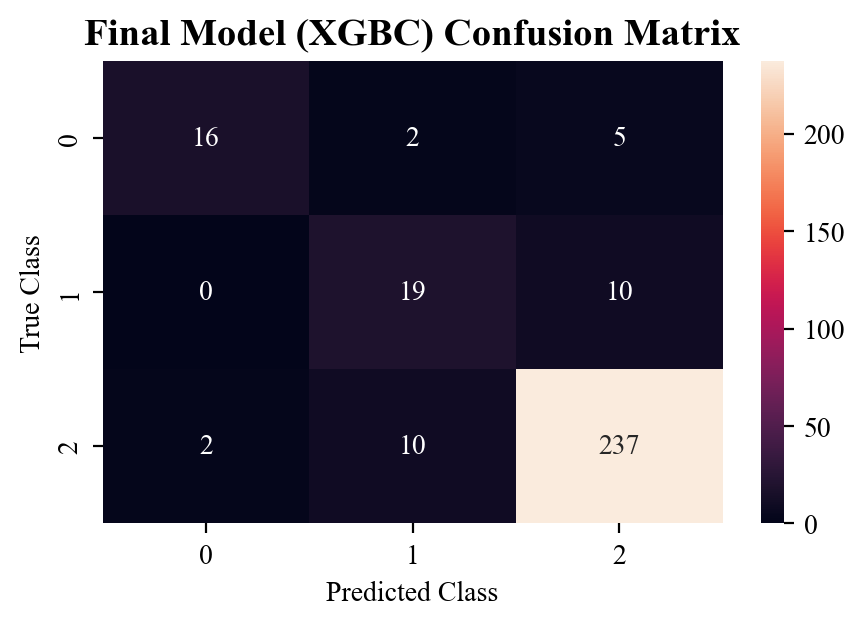

In [33]:
final_cm = confusion_matrix(y_test, final_pred)
plt.figure(figsize=(5,3), dpi=200)
sns.heatmap(final_cm, annot=True, fmt='d')
plt.title('Final Model (XGBC) Confusion Matrix', size=14, weight='bold')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

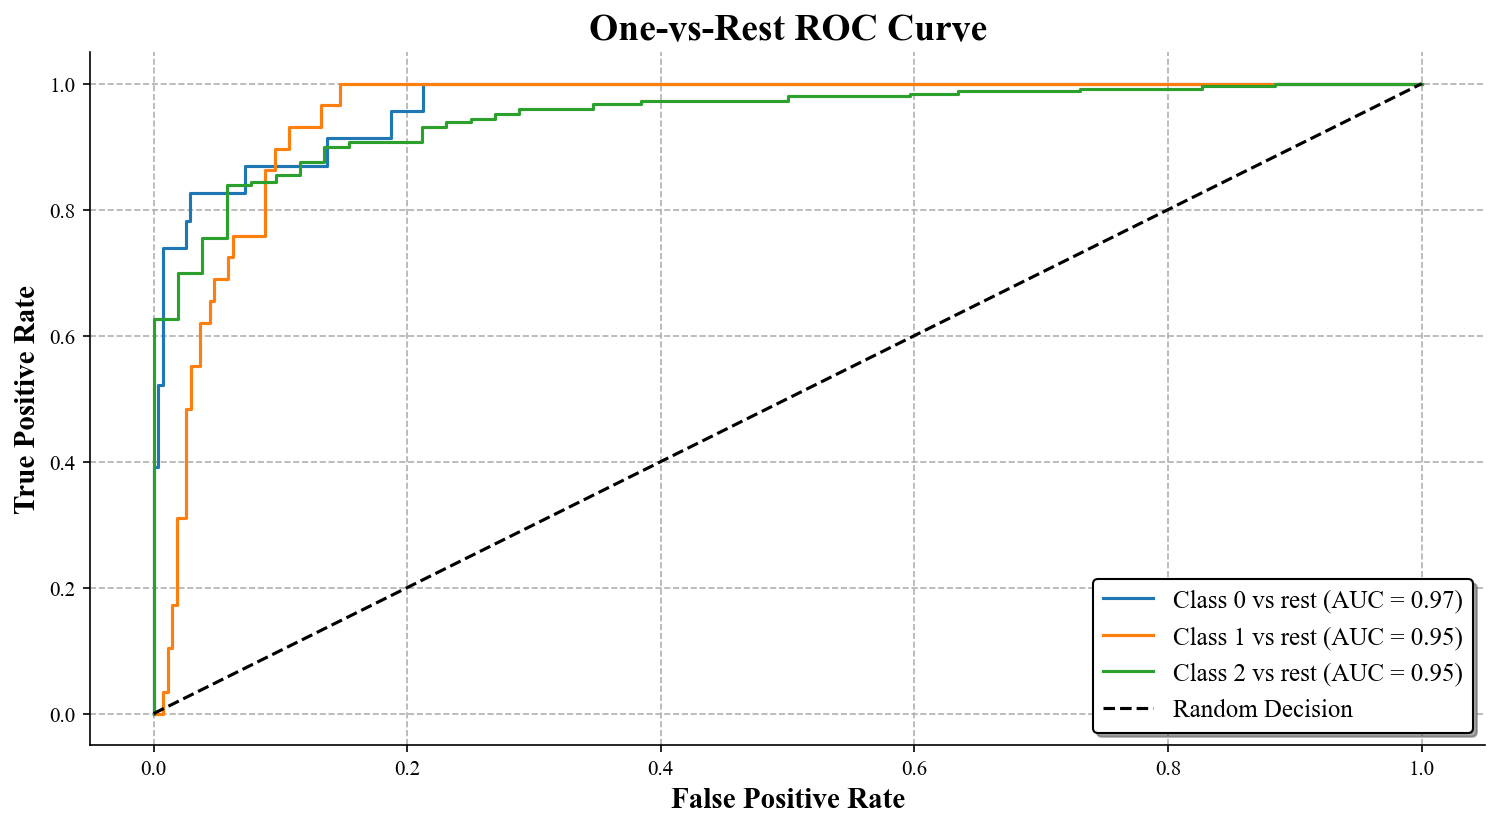

In [34]:
y_proba = final_model.predict_proba(x_test_flat)

classes = np.unique(y_val)
y_test_binary = label_binarize(y_test, classes=classes)


plt.figure(figsize=(12, 6), dpi=150)
for i, cls in enumerate(classes):
    fpr, tpr, thresholds = roc_curve(y_test_binary[:, i], y_proba[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {cls} vs rest (AUC = {auc_score:.2f})")


plt.plot([0, 1], [0, 1], 'k--', label='Random Decision')
plt.xlabel("False Positive Rate", size=14, weight='bold')
plt.ylabel("True Positive Rate", size=14, weight='bold')
plt.title("One-vs-Rest ROC Curve", size=18, weight='bold')
plt.legend(edgecolor='k', shadow=True,
          prop = {'size': 12})
plt.grid(ls='--')
sns.despine()
plt.show()

# 📈 Summary and Future Directions

The **XGBoost Classifier** demonstrates strong overall performance in predicting market regimes.  
While regime classes **0 (Strong Bull)** and **2 (Stable Bull)** are predicted with high accuracy,  
the confusion matrix reveals a consistent challenge in forecasting **Regime 1 (Panic)** using 7-day input windows.

### 🔍 Key Observations:
- **High precision and recall** for dominant regimes (0 and 2) indicate reliable structure detection.
- **Lower performance on Regime 1** suggests either insufficient signal or high overlap with other classes.
- Model may be more sensitive to stable patterns and less reactive to short-term volatility shifts typical of regime 1.

### 🚀 Suggested Next Steps:
- **Targeted binary classifier**: Build a dedicated model to detect **only Regime 1 vs. all others**,  
  which can help isolate panic conditions and reduce predictive noise.
- **Window optimization**: Experiment with different temporal window sizes (e.g., 3 or 10 days) to test signal sensitivity.
- **Feature refinement**: Focus on features most correlated with volatility or macro instability.

These refinements can enhance early detection of critical shifts and improve the model’s practical value for market surveillance and strategy adjustment.
